# PA3 Report

20160463 성해빈

## Faster RCNN
We use mmdetection. We use scripts in tools/ folder to do perform some functionalities, like training, testing, looking at learning curves, etc.  
models and checkpoints can be found in https://github.com/open-mmlab/mmdetection  
dataset could be found in http://host.robots.ox.ac.uk/pascal/VOC/voc2007/, I needed to merge trainval data and test data folders for mmdetection to work.

I used model `configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py` for this task.  
iou_thr could be set by --eval-options, which took me about 3 hours of searching and code analysis to find out.  
This library is so poorly documented.

And I also needed to fix `configs/_base_/datasets/voc0712.py` to make it not use VOC2012 on training.
```python
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='RepeatDataset',
        times=3,
        dataset=dict(
            type=dataset_type,
            ann_file=[
                data_root + 'VOC2007/ImageSets/Main/trainval.txt',
                #data_root + 'VOC2012/ImageSets/Main/trainval.txt'
            ],
            img_prefix=[data_root + 'VOC2007/',], # data_root + 'VOC2012/'],
            pipeline=train_pipeline)),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'VOC2007/ImageSets/Main/test.txt',
        img_prefix=data_root + 'VOC2007/',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'VOC2007/ImageSets/Main/test.txt',
        img_prefix=data_root + 'VOC2007/',
        pipeline=test_pipeline))
```  

[training](#Train:-Faster-RCNN) and [result](#Result:-Faster-RCNN) can be found below with code.  
trained model parameters are in google drive. https://drive.google.com/drive/folders/1Tld0qF_XVgFdlGEo-pms9d4_pmf-ICOD?usp=sharing  
here are the experimental results.  

|             | mAP@0.5 | mAP@0.6 | mAP@0.7 | mAP@0.8 | mAP@0.9 | FPS   |
|-------------|---------|---------|---------|---------|---------|-------|
| Faster RCNN | 0.718   | 0.654   | 0.530   | 0.321   | 0.072   | 20.89 |

Overall, even though it is "Faster" RCNN, training it was quite slow.  
FPS of 20.89 is quite decent compared to previous models, but not as good as real-time purpose.  
The IoU threshold controls the standard of being positive or not, so high threshold leads to lower mAP, which is obvious.  
But Faster RCNN seems to have a very low performance in higher IoU thresholds, which means it does detect the objects, but it rarely detects the objects accurately.  


## Mask RCNN
We use mmdetection again.  
But this time, we don't have a model that supports mask RCNN for VOC in mmdetection.  
We just make a config file, like https://github.com/open-mmlab/mmdetection/blob/master/docs/2_new_data_model.md#prepare-a-config

We make `configs/pascal_voc/mask_rcnn_r50_fpn_1x_voc0712.py`
```python
_base_ = [
    '../_base_/models/mask_rcnn_r50_fpn.py',
    '../_base_/datasets/voc0712.py',
    '../_base_/default_runtime.py'
]

model = dict(roi_head=dict(bbox_head=dict(num_classes=20), mask_head=dict(num_classes=20)))
# optimizer
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
# learning policy
# actual epoch = 3 * 3 = 9
lr_config = dict(policy='step', step=[3])
# runtime settings
total_epochs = 4  # actual epoch = 4 * 3 = 12

```

But I still got errors even though I did everything I could do.  
When I looked over github issues, i found out that  
**MMDETECTION DOES NOT SUPPORT MASK RELATED MODELS for PASCAL VOC CURRENTLY!!!!!!!!!** : https://github.com/open-mmlab/mmdetection/issues/1561  
I could remove the mask branch from Mask RCNN, but that has no difference with Faster RCNN.  
So I gave up using mmdetection for this task, **SINCE THE DEVELOPER OF MMDETECTION SAYS IT'S IMPOSSIBLE**.  


|           | mAP@0.5 | mAP@0.6 | mAP@0.7 | mAP@0.8 | mAP@0.9 | FPS |
|-----------|---------|---------|---------|---------|---------|-----|
| Mask RCNN | ?       | ?       | ?       | ?       | ?       | ?   |

You can see my [efforts](#Train:-Mask-RCNN) below, with the code.  


## YOLOv3
This model doesn't support VOC by default too.  
We do PASCAL VOC by adding a custom dataset, https://github.com/eriklindernoren/PyTorch-YOLOv3#train-on-custom-dataset  
But this custom dataset requires a different annotation format, so I converted the format using https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/519  
Then I could make a custom dataset.

I had some issues with TF 2.0, default installed by the requirements.txt because they didn't think of upper versions.  
fixed with https://github.com/eriklindernoren/PyTorch-YOLOv3/commit/930c5872eea3d22233805f3f693dd5c9a9892707  
also fixed annoying torch.uint8 warning with https://github.com/eriklindernoren/PyTorch-YOLOv3/pull/541/commits/7dd01ecd37ed56cecf14fc8f2ee531d5cba08315  
also neeeded to lower batch size to 4, https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/317

To make it work, I needed to tweak some hyperparameters like evaluation intervals, batch size, etc.  
Still, the model doesn't seem to work very well. 
If we look at the issues, there are a lot of people having trouble with VOC. https://github.com/eriklindernoren/PyTorch-YOLOv3/issues?page=1&q=voc  
So bad results are probably not due to my mistake.  


[training](#Train:-YOLOv3) and [result](#Result:-YOLOv3) can be found below with code.  
trained model parameters are in google drive. https://drive.google.com/drive/folders/1Tld0qF_XVgFdlGEo-pms9d4_pmf-ICOD?usp=sharing  
here are the experimental results.  

|        | mAP@0.5 | mAP@0.6 | mAP@0.7 | mAP@0.8 | mAP@0.9 | FPS  |
|--------|---------|---------|---------|---------|---------|------|
| YOLOv3 | 0.114   | 0.087   | 0.045   | 0.013   | 0.002   | 80.2 |

The repo doesn't support PASCAL by default, and it is known to have a problem in PASCAL VOC dataset (refer to the issues)   
So low mAP in PASCAL VOC seems to be a common issue in this repo.  
I trained about 100 epochs, which took me so much time, about 12 hours total.  
The training costed too much time, so even though the learning curve seemed to have some potential if I learn more,  
I couldn't proceed more training since I spent so much time on it.  
FPS is about 80, which is now quite real-time, if we think of standard fps as 60.  


## YOLOv5
We follow instructions from the pdf to train a custom dataset (mask wearing dataset)  
there was a typo, val -> valid
```yml
train: data/mask_wearing_db/train/images
val: data/mask_wearing_db/valid/images

nc: 2

names: ['mask', 'no-mask']
```

I needed to change utils/general.py a bit when I executed `from yolov5.utils.general import *` in the code below

```python
from utils.google_utils import gsutil_getsize
from utils.torch_utils import is_parallel, init_torch_seeds

INTO

from google_utils import gsutil_getsize
from torch_utils import is_parallel, init_torch_seeds
```
and turn it back when I executed test.py.

IoU threshold is controlled by --iou-thres argument in test.py.  
[training](#Train:-YOLOv5) and [result](#Result:-YOLOv5) can be found below with code.  
trained model parameters are in google drive. https://drive.google.com/drive/folders/1Tld0qF_XVgFdlGEo-pms9d4_pmf-ICOD?usp=sharing  
here are the experimental results.  

|        | mAP@0.5 | mAP@0.6 | mAP@0.7 | mAP@0.8 | mAP@0.9 | FPS    |
|--------|---------|---------|---------|---------|---------|--------|
| YOLOv5 | 0.643   | 0.636   | 0.624   | 0.594   | 0.474   | 263.15 |

WOW! YOLOv5 has quite accurate performance on even high IoU thresholds, and it is super fast in both training and Inference.  
Also, the utilities and the interface of this repo were much more friendly than mmdetection, just look at the plots they generate!  



## Train: Faster RCNN

In [1]:
# set path of mmdetection
mmdetection_path = '../../mmdetection/'

In [1]:
# train model
!cd {mmdetection_path} && python tools/train.py configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py

2020-11-07 00:30:05,206 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.8.3 (default, Jul  2 2020, 16:21:59) [GCC 7.3.0]
CUDA available: True
GPU 0: GeForce GTX 1080 Ti
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.2, V10.2.89
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.6.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.5.0 (Git Hash e2ac1fac44c5078ca927cb9b90e1b3066a0b2ed0)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch

## Result: Faster RCNN

In [ ]:
# set path of mmdetection
mmdetection_path = '../../mmdetection/'

plot curve of ../../mmdetection/work_dirs/faster_rcnn_r50_fpn_1x_voc0712/20201107_003005.log.json, metric is loss


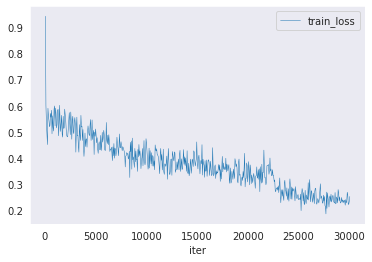

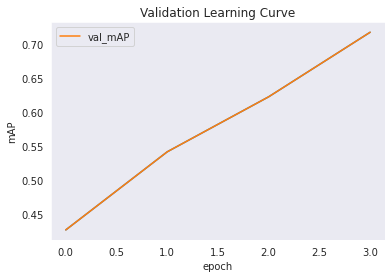

In [1]:
# get learning curve
import sys
sys.path.insert(0,'../../')
from mmdetection.tools.analyze_logs import main_p1

main_p1()
## I had to change code for inline plotting in jupyter
'''
def main_p1():
    from argparse import Namespace
    args = Namespace(backend=None, json_logs=['../../mmdetection/work_dirs/faster_rcnn_r50_fpn_1x_voc0712/20201107_003005.log.json'], keys=['loss'], legend=['train_loss'], out=None, style='dark', task='plot_curve', title=None)
    json_logs = args.json_logs
    for json_log in json_logs:
        assert json_log.endswith('.json')

    log_dicts = load_json_logs(json_logs)

    eval(args.task)(log_dicts, args)
'''


import matplotlib.pyplot as plt

val_mAP = [0.427, 0.542, 0.623, 0.718] # val mAP
plt.plot(val_mAP)
plt.title("Validation Learning Curve")
plt.xlabel("epoch")
plt.ylabel("mAP")
plt.plot(val_mAP, label='val_mAP')
plt.legend()
plt.show()

In [9]:
# test model
print("mAP@0.5")
!cd {mmdetection_path} && python tools/test.py configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py work_dirs/faster_rcnn_r50_fpn_1x_voc0712/latest.pth --eval mAP --eval-options iou_thr=0.5
print("mAP@0.6")
!cd {mmdetection_path} && python tools/test.py configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py work_dirs/faster_rcnn_r50_fpn_1x_voc0712/latest.pth --eval mAP --eval-options iou_thr=0.6
print("mAP@0.7")
!cd {mmdetection_path} && python tools/test.py configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py work_dirs/faster_rcnn_r50_fpn_1x_voc0712/latest.pth --eval mAP --eval-options iou_thr=0.7
print("mAP@0.8")
!cd {mmdetection_path} && python tools/test.py configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py work_dirs/faster_rcnn_r50_fpn_1x_voc0712/latest.pth --eval mAP --eval-options iou_thr=0.8
print("mAP@0.9")
!cd {mmdetection_path} && python tools/test.py configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py work_dirs/faster_rcnn_r50_fpn_1x_voc0712/latest.pth --eval mAP --eval-options iou_thr=0.9

mAP@0.5
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4952/4952, 21.3 task/s, elapsed: 233s, ETA:     0s
+-------------+------+-------+--------+-------+
| class       | gts  | dets  | recall | ap    |
+-------------+------+-------+--------+-------+
| aeroplane   | 285  | 809   | 0.856  | 0.756 |
| bicycle     | 337  | 1095  | 0.923  | 0.809 |
| bird        | 459  | 1230  | 0.821  | 0.718 |
| boat        | 263  | 1488  | 0.802  | 0.565 |
| bottle      | 469  | 1202  | 0.719  | 0.595 |
| bus         | 213  | 902   | 0.939  | 0.787 |
| car         | 1201 | 2937  | 0.914  | 0.853 |
| cat         | 358  | 1277  | 0.939  | 0.802 |
| chair       | 756  | 3639  | 0.804  | 0.579 |
| cow         | 244  | 1214  | 0.914  | 0.701 |
| diningtable | 206  | 1448  | 0.859  | 0.649 |
| dog         | 489  | 1913  | 0.943  | 0.783 |
| horse       | 348  | 1234  | 0.928  | 0.798 |
| motorbike   | 325  | 1091  | 0.905  | 0.789 |
| person      | 4528 | 12028 | 0.915  | 0.827 |
| pottedplant | 480  | 1654  | 0.700  | 0.468 |


In [33]:
print("FPS : 4952 image / 236 sec = {} FPS".format(4952 / 237))

FPS : 4952 image / 236 sec = 20.89451476793249 FPS


## Train: Mask RCNN


In [3]:
# set path of mmdetection
mmdetection_path = '../../mmdetection/'

In [14]:
# train model
!cd {mmdetection_path} && python tools/train.py configs/pascal_voc/mask_rcnn_r50_fpn_1x_voc0712.py

2020-11-07 15:13:49,903 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.8.3 (default, Jul  2 2020, 16:21:59) [GCC 7.3.0]
CUDA available: True
GPU 0: GeForce GTX 1080 Ti
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.2, V10.2.89
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.6.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v1.5.0 (Git Hash e2ac1fac44c5078ca927cb9b90e1b3066a0b2ed0)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch

## Result: Mask RCNN

In [ ]:
# set path of mmdetection
mmdetection_path = '../../mmdetection/'

In [ ]:
# get learning curve

In [15]:
# test model
print("mAP@0.5")
!cd {mmdetection_path} && python tools/test.py configs/pascal_voc/mask_rcnn_r50_fpn_1x_voc0712.py checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth --eval mAP --eval-options iou_thr=0.5

mAP@0.5
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([21, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([21]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([80, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([80]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits.bias: copying a param with shape to

## Train: YOLOv3

In [5]:
# set path of YOLOv3
yolov3_path = '../../PyTorch-YOLOv3/'

In [42]:
# convert VOC to YOLO format
VOC_path = '~/Downloads/VOCtrainval_06-Nov-2007'
!cd {VOC_path} && python VOC_to_YOLO.py --images=VOCdevkit/VOC2007/JPEGImages/ --annotation=VOCdevkit/VOC2007/Annotations/ --VOCtoYOLO=True --classes=classes.txt

I1107 17:26:13.055763 139935756134208 VOC_to_YOLO.py:118] Copied 5011 Images and Annotation


In [9]:
# train model
!cd {yolov3_path} && python3 train.py --model_def config/yolov3-custom.cfg --data_config config/custom.data --pretrained_weights weights/darknet53.conv.74 --batch_size 4 --compute_map True --evaluation_interval 10

2020-11-07 20:32:01.465277: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-11-07 20:32:01.465304: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Namespace(batch_size=4, checkpoint_interval=1, compute_map='True', data_config='config/custom.data', epochs=100, evaluation_interval=10, gradient_accumulations=2, img_size=416, model_def='config/yolov3-custom.cfg', multiscale_training=True, n_cpu=8, pretrained_weights='weights/darknet53.conv.74')
2020-11-07 20:32:02.233533: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-07 20:32:02.253663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at le

## Result: YOLOv3

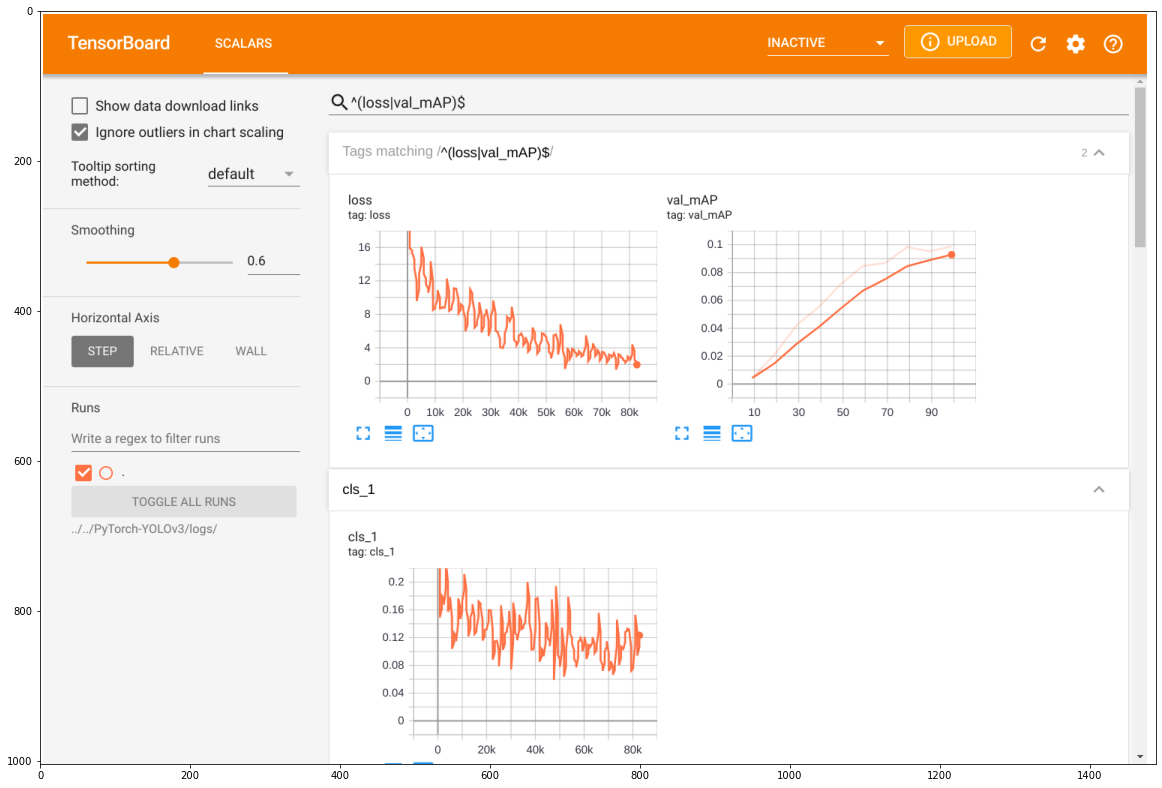

In [4]:
# get learning curve

#%load_ext tensorboard
#%tensorboard --logdir ../../PyTorch-YOLOv3/logs/


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('tensorboard_screenshot.png')
plt.figure(figsize=(20,20))
imgplot = plt.imshow(img)
plt.show()

In [19]:
# test model

print("mAP@0.5")
!cd {yolov3_path} && python3 test.py --iou_thres 0.5 --model_def config/yolov3-custom.cfg --data_config config/custom.data --weights_path checkpoints/yolov3_ckpt_99.pth --class_path data/custom/classes.names 
print("mAP@0.6")
!cd {yolov3_path} && python3 test.py --iou_thres 0.6 --model_def config/yolov3-custom.cfg --data_config config/custom.data --weights_path checkpoints/yolov3_ckpt_99.pth --class_path data/custom/classes.names
print("mAP@0.7")
!cd {yolov3_path} && python3 test.py --iou_thres 0.7 --model_def config/yolov3-custom.cfg --data_config config/custom.data --weights_path checkpoints/yolov3_ckpt_99.pth --class_path data/custom/classes.names
print("mAP@0.8")
!cd {yolov3_path} && python3 test.py --iou_thres 0.8 --model_def config/yolov3-custom.cfg --data_config config/custom.data --weights_path checkpoints/yolov3_ckpt_99.pth --class_path data/custom/classes.names
print("mAP@0.9")
!cd {yolov3_path} && python3 test.py --iou_thres 0.9 --model_def config/yolov3-custom.cfg --data_config config/custom.data --weights_path checkpoints/yolov3_ckpt_99.pth --class_path data/custom/classes.names

mAP@0.5
Namespace(batch_size=8, class_path='data/custom/classes.names', conf_thres=0.001, data_config='config/custom.data', img_size=416, iou_thres=0.5, model_def='config/yolov3-custom.cfg', n_cpu=8, nms_thres=0.5, weights_path='checkpoints/yolov3_ckpt_99.pth')
Compute mAP...
Computing AP: 100%|█████████████████████████████| 20/20 [00:00<00:00, 58.31it/s]
Average Precisions:
+ Class '0' (aeroplane) - AP: 0.1530652409016597
+ Class '1' (bicycle) - AP: 0.14798731168285376
+ Class '2' (bird) - AP: 0.017546367443066167
+ Class '3' (boat) - AP: 0.04422227318081075
+ Class '4' (bottle) - AP: 0.032340131109283826
+ Class '5' (bus) - AP: 0.044419933502564256
+ Class '6' (car) - AP: 0.30966752105915835
+ Class '7' (cat) - AP: 0.14431684372223783
+ Class '8' (chair) - AP: 0.07592321764975055
+ Class '9' (cow) - AP: 0.04800434352065731
+ Class '10' (diningtable) - AP: 0.07549277513615114
+ Class '11' (dog) - AP: 0.10663636188189582
+ Class '12' (horse) - AP: 0.11788150463632961
+ Class '13' (moto

In [20]:
print("FPS : 4.05 iter * 20 class / 1 sec = {} FPS".format(4.05 * 20))

FPS : 4.05 iter * 20 class / 1 sec = 81.0 FPS


## Train: YOLOv5

In [16]:
# set path of YOLOv5
yolov5_path = '../../yolov5/'

In [18]:
# train model
!cd {yolov5_path} && python train.py --data mask.yaml --img-size 416 416 --cfg ./models/yolov5s.yaml --weight yolov5s.pt

Your branch is behind 'origin/master' by 2 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='./models/yolov5s.yaml', data='./data/mask.yaml', device='', epochs=300, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, log_imgs=10, logdir='runs/', multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-11-07 15:36:43.342617: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: 

## Result: YOLOv5

In [6]:
# set path of YOLOv5
yolov5_path = '../../yolov5/'

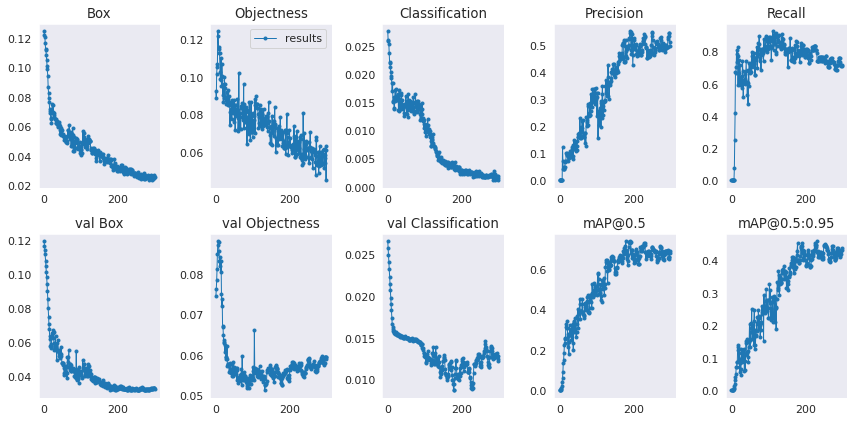

In [28]:
# get learning curve
import sys
sys.path.insert(0,'../../')
from yolov5.utils.general import *

plot_results(save_dir='../../yolov5/runs/exp1')

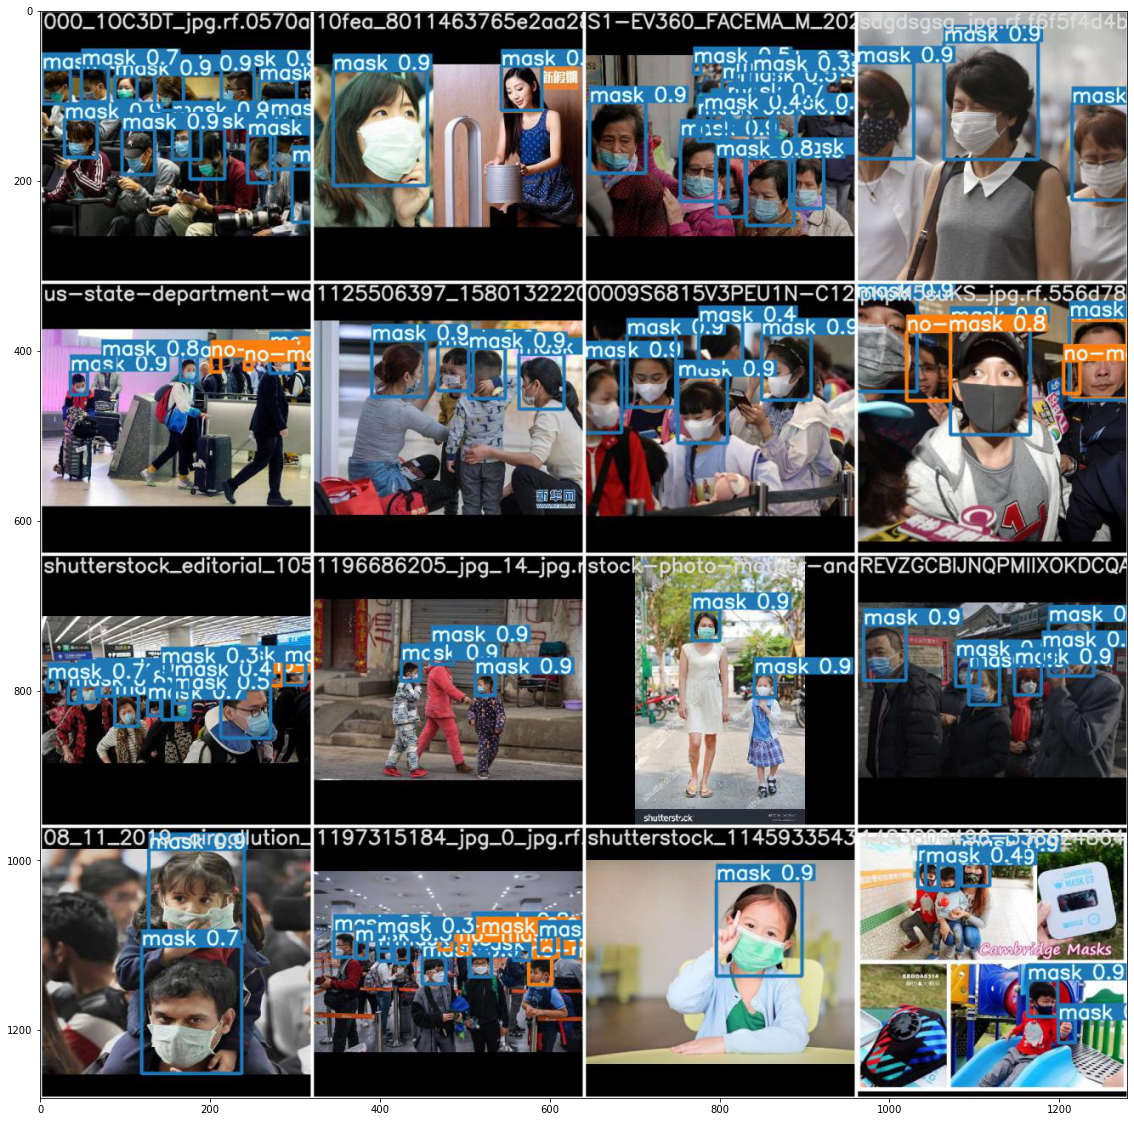

In [7]:
# result images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(yolov5_path + 'runs/exp1/test_batch0_pred.jpg')
plt.figure(figsize=(20,20))
imgplot = plt.imshow(img)
plt.show()

In [32]:
# test model

print("mAP@0.5")
!cd {yolov5_path} && python test.py --weights runs/exp1/weights/last.pt --data mask.yaml --img-size 416 --iou-thres 0.5
print("mAP@0.6")
!cd {yolov5_path} && python test.py --weights runs/exp1/weights/last.pt --data mask.yaml --img-size 416 --iou-thres 0.6
print("mAP@0.7")
!cd {yolov5_path} && python test.py --weights runs/exp1/weights/last.pt --data mask.yaml --img-size 416 --iou-thres 0.7
print("mAP@0.8")
!cd {yolov5_path} && python test.py --weights runs/exp1/weights/last.pt --data mask.yaml --img-size 416 --iou-thres 0.8
print("mAP@0.9")
!cd {yolov5_path} && python test.py --weights runs/exp1/weights/last.pt --data mask.yaml --img-size 416 --iou-thres 0.9

mAP@0.5
Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/mask.yaml', device='', img_size=416, iou_thres=0.5, save_conf=False, save_dir='runs/test', save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['runs/exp1/weights/last.pt'])
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Fusing layers... 
Model Summary: 140 layers, 7.24922e+06 parameters, 0 gradients
Scanning labels data/mask_wearing_db/valid/labels.cache (29 found, 0 missing, 0 empty, 0 duplicate, for 29 images): 29it [00:00, 19659.74it/s]
               Class      Images     Targets           P           R      mAP@.5
                 all          29         162       0.502       0.715       0.643       0.411
Speed: 2.1/1.2/3.3 ms inference/NMS/total per 416x416 image at batch-size 32
Results saved to runs/test
mAP@0.6
Namespace(augment=False, batch_size=32, conf_thres=0.001, data='./data/mask.yaml', device='', img_size=416, iou

In [34]:
print("FPS : 1 image / 0.0038 sec = {} FPS".format(1 / 0.0038))

FPS : 1 image / 0.0038 sec = 263.1578947368421 FPS
